### Data sources

Inhabitants' median disposable monetary income by postal code area, 2010-2021:

https://pxdata.stat.fi:443/PxWeb/sq/39625562-d250-492a-a190-37bcc355e2a3

Prices per square meter of old dwellings in housing companies and numbers of transactions by postal code area, yearly, 2009-2022:

https://pxdata.stat.fi:443/PxWeb/sq/41826b15-82a9-4c83-8be6-bd77f98b31ac

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from random import randint

# Output control. Set these true, and more output will be generated.
DO_CORRELATION_PLOTS = False
DO_PEEK_IN_DATA = False

# Read in what we've got.
incomes = pd.read_csv('../data/003_12f1_2021_20230929-100110.csv',
                      encoding = 'latin1',
                      na_values = [ '0' ],
                      skiprows = [0, 1])
prices = pd.read_csv('../data/001_13mu_2022_20230929-105546.csv',
                     encoding = 'latin1',
                     na_values = [ '.', '..', '...' ],
                     skiprows = [0, 1])

# Setup things the way specified above.

# Correlation plots are needed when trying to home on in P, Q, and D values for ARIMA modelling.
# Most of the time they're just unnecessary clutter; so, by default they're not produced.
if DO_CORRELATION_PLOTS:
  import matplotlib.pyplot as plt
  from pandas.plotting import autocorrelation_plot

In [2]:
if DO_PEEK_IN_DATA:
  # A few peeks in to the data we just read.
  print(f'Income/Price data shape: {incomes.shape}/{prices.shape}\n')

  print(incomes.iloc[[randint(0, incomes.shape[0])]].to_string())
  print(prices.iloc[[randint(0, prices.shape[0])]].to_string())

In [3]:
# Drop unwanted columns for ease of use later on.
incomes.drop('Information', axis = 1, inplace = True)
prices.drop([ 'Building type', 'Information' ], axis = 1, inplace = True)

# Postal codes are unique, and they're also used as identifiers in GeoJSON
# containing borders of postal code areas; so, we might separate them from
# more traditional names.
prices.insert(
  loc = 1,
  column = 'Name',
  value = prices['Postal code'].map(lambda _: ' '.join(filter(lambda x: len(x) > 0,
                                                              _.split(' ')[1:])))
)
prices['Postal code'] = prices['Postal code'].map(lambda _: _.split(' ')[0])

incomes.insert(
  loc = 0,
  column = 'Name',
  value = incomes['Postal code area'].map(lambda _: ' '.join(filter(lambda x: len(x) > 0,
                                                                    _.split(' ')[1:])))
)
incomes.insert(loc = 0,
               column = 'Postal code',
               value = incomes['Postal code area'].map(lambda _: _.split(' ')[0]))
incomes.drop('Postal code area', axis = 1, inplace = True)

In [4]:
if DO_PEEK_IN_DATA:
  # A few more peeks into the data, which should now appear more uniform than before.
  print(f'Income/Price data shape: {incomes.shape}/{prices.shape}\n')

  code = incomes.iloc[[randint(0, min(incomes.shape[0], prices.shape[0]))]]['Postal code'].values[0]
  print(incomes.loc[incomes['Postal code'] == code])
  print(prices.loc[prices['Postal code'] == code])

  ax_incomes = incomes.plot()
  ax_incomes.set_xlabel('Postal code')
  ax_incomes.set_ylabel('Median Disposable Income')
  _ = ax_incomes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  ax_prices = prices.plot()
  ax_prices.set_xlabel('Postal code')
  ax_prices.set_ylabel('2 room flat sqm price')
  _ = ax_prices.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [5]:
if DO_CORRELATION_PLOTS:
  plotdata = incomes.drop('Name', axis = 1)
  for r in range(0, incomes.shape[0]):
    postal_code = incomes.iloc[[r]]['Postal code'].values[0]
    name = incomes.iloc[[r]]['Name'].values[0]
    ax = autocorrelation_plot(plotdata.iloc[[r]].T.iloc[1:])

    plt.title(f'{postal_code} {name}')
    plt.show()

In [6]:
if DO_CORRELATION_PLOTS:
  plotdata = prices.drop('Name', axis = 1)
  for r in range(0, prices.shape[0]):
    postal_code = prices.iloc[[r]]['Postal code'].values[0]
    name = prices.iloc[[r]]['Name'].values[0]
    ax = autocorrelation_plot(plotdata.iloc[[r]].T.iloc[1:])

    plt.title(f'{postal_code} {name}')
    plt.show()

### Arima Modelling

In ARIMA modelling below values P=3, Q=1, and D=4 are used. However, the values used originate from (an embarrassingly large set of) trial and error; so, this set of values might not be the best possible values. But, they're _a_ set of values producing no _negative_ predictions, which probably counts for this set's merit.

Documentation:

  https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
  https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html

Some background information for those who might be willing to wade through some:

  https://stats.stackexchange.com/questions/44992
  https://blog.devgenius.io/finding-optimal-p-d-and-q-values-for-your-arima-model-94669a909a35
  https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

In [7]:
income_predictions = []
income_deltas = []
income_percent_deltas = []

for r in range(0, incomes.shape[0]):
  # A few prints every now and then helps when locating where exactly warnings came from.
  print(incomes.iloc[[r]]['Name'].values[0])
  print(incomes.iloc[[r]].to_string())

  history = incomes.drop(['Name', 'Postal code'], axis = 1).rename({ 3: 'Income' }).iloc[[r]].T
  history.index = pd.date_range(freq = 'AS-JAN',
                                periods = len(history.index),
                                start = history.index[0])
  model = ARIMA(history, enforce_stationarity = False, order = (3, 1, 4))
  fitted_model = model.fit()
  prediction = fitted_model.forecast().values[0]

  income_predictions.append(prediction)
  delta = prediction - incomes.iloc[r, incomes.shape[1] - 1]
  income_deltas.append(delta)
  income_percent_deltas.append((delta / prediction) * 100)

  # A few prints every now and then helps when locating where exactly warnings came from.
  print(f'    {prediction}')

incomes.insert(column = str(int(incomes.columns[-1]) + 1),
               loc = incomes.shape[1],
               value = income_predictions)
incomes.insert(column = 'Delta',
               loc = incomes.shape[1],
               value = income_deltas)
incomes.insert(column = 'Delta Percent',
               loc = incomes.shape[1],
               value = income_percent_deltas)

Helsinki keskusta - Etu-Töölö (Helsinki)
  Postal code                                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
0       00100  Helsinki keskusta - Etu-Töölö (Helsinki)  23296.0  24089.0  24784.0  25148.0  25607.0  25986.0  26642.0  27577.0  28694.0  29706.0  29258.0  30659.0
    30888.798973067187
Punavuori - Bulevardi (Helsinki)
  Postal code                              Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
1       00120  Punavuori - Bulevardi (Helsinki)  24084.0  24941.0  25865.0  25830.0  26219.0  26284.0  27107.0  27518.0  28726.0  29816.0  29684.0  30668.0
    30923.836080481586
Kaartinkaupunki (Helsinki)
  Postal code                        Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
2       00130  Kaartinkaupunki (Helsinki)  25176.0  24541.0  27

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    29517.601959809333
Katajanokka (Helsinki)
  Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
5       00160  Katajanokka (Helsinki)  24671.0  25220.0  25848.0  26154.0  26665.0  27188.0  27264.0  28092.0  28971.0  30168.0  30270.0  30520.0
    30158.019476704736
Kruununhaka (Helsinki)
  Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
6       00170  Kruununhaka (Helsinki)  24669.0  25461.0  26308.0  26729.0  27199.0  27358.0  27846.0  28489.0  29627.0  30720.0  30591.0  31048.0
    31212.633750302914
Kamppi - Ruoholahti (Helsinki)
  Postal code                            Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
7       00180  Kamppi - Ruoholahti (Helsinki)  22646.0  23102.0  23349.0  23518.0  23902.0  24243.0  24898.0  25492.

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to esti

    29272.782692559962
Helsinki postikeskus (Helsinki)
   Postal code                             Name  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021
12       00230  Helsinki postikeskus (Helsinki)   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
    0.0
Länsi-Pasila (Helsinki)
   Postal code                     Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
13       00240  Länsi-Pasila (Helsinki)  20477.0  20763.0  21609.0  22108.0  22224.0  22501.0  22600.0  23045.0  24146.0  25322.0  25552.0  26678.0
    27966.10600872984
Taka-Töölö (Helsinki)
   Postal code                   Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
14       00250  Taka-Töölö (Helsinki)  22426.0  22911.0  23831.0  24172.0  24332.0  24745.0  25197.0  25958.0  26636.0  27726.0  27627.0  28321.0
    25393.026903882183
Keski-Töölö (Helsi

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    26312.173500634355
Kivihaka (Helsinki)
   Postal code                 Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
20       00310  Kivihaka (Helsinki)  22159.0  22133.0  23052.0  23278.0  23344.0  23346.0  23744.0  24419.0  24805.0  24998.0  25047.0  26720.0
    24935.465866968414
Etelä-Haaga (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
21       00320  Etelä-Haaga (Helsinki)  21311.0  21706.0  22433.0  22731.0  23136.0  23266.0  23841.0  24399.0  25297.0  26496.0  26541.0  27524.0
    27881.904217168794
Munkkiniemi (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
22       00330  Munkkiniemi (Helsinki)  24705.0  25110.0  25736.0  26120.0  26686.0  27081.0  27409.0  27897.0  29135.0  30028.0  30423.

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    26696.183562912185
Reimarla (Helsinki)
   Postal code                 Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
26       00370  Reimarla (Helsinki)  21312.0  21823.0  22480.0  22645.0  22716.0  22751.0  22813.0  23333.0  23930.0  24608.0  25133.0  25767.0
    26138.17652796604
Pitäjänmäen yritysalue (Helsinki)
   Postal code                               Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
27       00380  Pitäjänmäen yritysalue (Helsinki)  22014.0  22264.0  23159.0  23343.0  23191.0  23384.0  23516.0  24047.0  24334.0  25110.0  25697.0  26072.0
    22056.665360980744
Konala (Helsinki)
   Postal code               Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
28       00390  Konala (Helsinki)  21724.0  22356.0  22951.0  23227.0  23439.0  23388.0  23522.0  24080.0  24292.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    24450.44515479017
Maununneva - Kuninkaantammi (Helsinki)
   Postal code                                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
32       00430  Maununneva - Kuninkaantammi (Helsinki)  24977.0  25597.0  26538.0  26878.0  26526.0  26796.0  26959.0  26859.0  27537.0  27819.0  27763.0  28797.0
    29359.963284886806
Lassila (Helsinki)
   Postal code                Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
33       00440  Lassila (Helsinki)  19356.0  19765.0  20767.0  20799.0  21070.0  21435.0  21449.0  22065.0  22781.0  24153.0  23842.0  24470.0
    23533.545136014654
Sörnäinen - Harju (Helsinki)
   Postal code                          Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
34       00500  Sörnäinen - Harju (Helsinki)  18567.0  19132.0  19898.0  20188.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    23533.200580352976
Kalasatama - Sompasaari (Helsinki)
   Postal code                                Name  2010  2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
38       00540  Kalasatama - Sompasaari (Helsinki)   NaN   NaN  16912.0  21234.0  22533.0  24339.0  25322.0  26242.0  28022.0  28509.0  28866.0  30132.0
    30968.771967199777
Vallila - Hermanni (Helsinki)
   Postal code                           Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
39       00550  Vallila - Hermanni (Helsinki)  17959.0  18455.0  19360.0  19317.0  19755.0  20318.0  20543.0  21397.0  22492.0  23405.0  23601.0  23854.0
    23923.468286967935
Toukola - Kumpula - Vanhakaupunki (Helsinki)
   Postal code                                          Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
40       00560  Toukola - Kumpula - Va

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    27453.460677906387
Koskela (Helsinki)
   Postal code                Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
44       00600  Koskela (Helsinki)  16568.0  16631.0  17300.0  17742.0  17919.0  18259.0  18418.0  18699.0  19268.0  19915.0  20769.0  21890.0
    23296.25194077377
Käpylä (Helsinki)
   Postal code               Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
45       00610  Käpylä (Helsinki)  21225.0  21599.0  22517.0  22817.0  23178.0  23464.0  23893.0  24240.0  25228.0  26276.0  26208.0  26924.0
    27704.40975181826
Metsälä - Etelä-Oulunkylä (Helsinki)
   Postal code                                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
46       00620  Metsälä - Etelä-Oulunkylä (Helsinki)  21796.0  22840.0  23670.0  23854.0  24099.0  24457.0  25230.0  24966.0  26

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    31602.57485116488
Länsi-Pakila (Helsinki)
   Postal code                     Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
50       00660  Länsi-Pakila (Helsinki)  26826.0  27623.0  28313.0  28773.0  28917.0  29367.0  29506.0  30046.0  31174.0  32594.0  33051.0  34117.0
    35076.13270311943
Paloheinä (Helsinki)
   Postal code                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
51       00670  Paloheinä (Helsinki)  28460.0  29110.0  30303.0  30139.0  30416.0  31147.0  31431.0  32090.0  33186.0  34225.0  34005.0  35431.0
    36095.70943757633
Itä-Pakila (Helsinki)
   Postal code                   Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
52       00680  Itä-Pakila (Helsinki)  26071.0  27045.0  27752.0  28357.0  28180.0  28198.0  29168.0  29228.0  30405.0  31182.0  31578.

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    23645.988624850805
Pukinmäki (Helsinki)
   Postal code                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
56       00720  Pukinmäki (Helsinki)  19645.0  20039.0  20859.0  20907.0  21066.0  21441.0  21474.0  21748.0  22516.0  23092.0  23187.0  23874.0
    24840.278192997714
Tapanila (Helsinki)
   Postal code                 Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
57       00730  Tapanila (Helsinki)  23211.0  23622.0  24321.0  24649.0  24731.0  24966.0  25246.0  25673.0  26319.0  27123.0  27223.0  28064.0
    29697.129970224847
Siltamäki (Helsinki)
   Postal code                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
58       00740  Siltamäki (Helsinki)  21048.0  21404.0  22054.0  22237.0  22345.0  22477.0  22602.0  23060.0  23996.0  24819.0  24832.0  25507.0
 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    22501.64127606807
Tapaninvainio (Helsinki)
   Postal code                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
62       00780  Tapaninvainio (Helsinki)  23308.0  23687.0  24321.0  24423.0  24733.0  24918.0  24916.0  25571.0  26272.0  27190.0  27259.0  28412.0
    28065.16640234825
Viikki (Helsinki)
   Postal code               Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
63       00790  Viikki (Helsinki)  21163.0  21334.0  21862.0  22052.0  22019.0  22361.0  22814.0  23199.0  23454.0  24051.0  24397.0  24952.0
    25542.106264734375
Länsi-Herttoniemi (Helsinki)
   Postal code                          Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
64       00800  Länsi-Herttoniemi (Helsinki)  19235.0  19548.0  20019.0  20422.0  20911.0  21171.0  21527.0  22253.0  23356.0 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    35931.31542110828
Yliskylä (Helsinki)
   Postal code                 Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
68       00840  Yliskylä (Helsinki)  23491.0  23620.0  24381.0  24510.0  24565.0  24910.0  25056.0  25357.0  26154.0  27094.0  26910.0  27870.0
    30462.746705728543
Jollas (Helsinki)
   Postal code               Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
69       00850  Jollas (Helsinki)  27683.0  27830.0  28970.0  29210.0  28769.0  29488.0  29686.0  30567.0  31560.0  32070.0  32089.0  34403.0
    33514.62850913779
Santahamina (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
70       00860  Santahamina (Helsinki)  25570.0  25813.0  26495.0  27492.0  27735.0  28097.0  28594.0  28334.0  29560.0  30288.0  31091.0  32024.0
    31

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    34508.790732684945
Puotinharju (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
74       00900  Puotinharju (Helsinki)  18411.0  18691.0  18928.0  19121.0  19241.0  19452.0  19886.0  20273.0  20661.0  21429.0  21690.0  21672.0
    23621.76586798337
Puotila (Helsinki)
   Postal code                Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
75       00910  Puotila (Helsinki)  19014.0  19292.0  19973.0  20333.0  20719.0  20710.0  20959.0  21403.0  22012.0  22824.0  22801.0  23238.0
    23632.385693344848
Myllypuro (Helsinki)
   Postal code                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
76       00920  Myllypuro (Helsinki)  19079.0  19456.0  20499.0  20786.0  21174.0  21352.0  21809.0  22284.0  22723.0  23556.0  23865.0  24566.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    29554.471825678123
Pohjois-Vuosaari (Helsinki)
   Postal code                         Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
80       00960  Pohjois-Vuosaari (Helsinki)  20917.0  21329.0  21678.0  21734.0  21956.0  22041.0  22190.0  22356.0  22954.0  23705.0  23545.0  23882.0
    27097.101996788653
Mellunmäki (Helsinki)
   Postal code                   Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
81       00970  Mellunmäki (Helsinki)  19446.0  19923.0  20311.0  20771.0  20757.0  20861.0  20952.0  21374.0  22009.0  22305.0  22425.0  22841.0
    23184.52820049322
Etelä-Vuosaari (Helsinki)
   Postal code                       Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
82       00980  Etelä-Vuosaari (Helsinki)  19808.0  20026.0  20550.0  20788.0  20761.0  20824.0  20968.0  2114

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
price_predictions = []
price_deltas = []
price_percent_deltas = []

for r in range(0, prices.shape[0]):
  # A few prints every now and then helps when locating where exactly warnings came from.
  print(prices.iloc[[r]]['Name'].values[0])
  print(prices.iloc[[r]].to_string())

  history = prices.drop(['Name', 'Postal code'], axis = 1).rename({ 3: 'Price' }).iloc[[r]].T
  history.index = pd.date_range(freq = 'AS-JAN',
                                periods = len(history.index),
                                start = history.index[0])
  model = ARIMA(history, enforce_stationarity = False, order = (3, 1, 4))
  fitted_model = model.fit()
  prediction = fitted_model.forecast().values[0]

  price_predictions.append(prediction)
  delta = prediction - prices.iloc[r, prices.shape[1] - 1]
  price_deltas.append(delta)
  price_percent_deltas.append((delta / prediction) * 100)

  # A few prints every now and then helps when locating where exactly warnings came from.
  print(f'    {prediction}')

prices.insert(column = str(int(prices.columns[-1]) + 1),
              loc = prices.shape[1],
              value = price_predictions)
prices.insert(column = 'Delta',
              loc = prices.shape[1],
              value = price_deltas)
prices.insert(column = 'Delta Percent',
              loc = prices.shape[1],
              value = price_percent_deltas)

Helsinki keskusta - Etu-Töölö (Helsinki)
  Postal code                                      Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
0       00100  Helsinki keskusta - Etu-Töölö (Helsinki)  4470.0  5104.0  5744.0  5898.0  6092.0  6003.0  6313.0  6138.0  6772.0  7098.0  7259.0  7773.0  8094.0  8357.0


/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    9058.212601170071
Punavuori - Bulevardi (Helsinki)
  Postal code                              Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
1       00120  Punavuori - Bulevardi (Helsinki)  5044.0  5420.0  5490.0  5876.0  6256.0  5929.0  6372.0  6428.0  6867.0  7454.0  7538.0  7993.0  8683.0  8665.0
    9486.792721790827
Kaartinkaupunki (Helsinki)
  Postal code                        Name    2009    2010    2011    2012    2013    2014  2015    2016    2017    2018    2019    2020    2021     2022
2       00130  Kaartinkaupunki (Helsinki)  5333.0  5870.0  6316.0  6327.0  6577.0  6794.0   NaN  7474.0  7487.0  7960.0  8084.0  8588.0  9480.0  10691.0
    13291.732864577978
Kaivopuisto - Ullanlinna (Helsinki)
  Postal code                                 Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
3       00140  Kaivopuisto - Ullanlinna (Helsink

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    7833.9452925229225
Kruununhaka (Helsinki)
  Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
6       00170  Kruununhaka (Helsinki)  4575.0  5265.0  5773.0  5761.0  6179.0  5972.0  6229.0  6276.0  6838.0  7186.0  7365.0  7770.0  7965.0  8382.0


/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    8595.819396352106
Kamppi - Ruoholahti (Helsinki)
  Postal code                            Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
7       00180  Kamppi - Ruoholahti (Helsinki)  4564.0  5055.0  5407.0  5585.0  5710.0  5901.0  6122.0  6299.0  6694.0  7053.0  6987.0  7863.0  7877.0  7940.0
    9814.886111209631
Suomenlinna (Helsinki)
  Postal code                    Name  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
8       00190  Suomenlinna (Helsinki)   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
    0.0
Pohjois-Lauttasaari (Helsinki)
  Postal code                            Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
9       00200  Pohjois-Lauttasaari (Helsinki)  3616.0  4091.0  4405.0  4574.0  4826.0  4853.0  4945.0  5079.0  5423.0  5779.0  5966.0  6531.0  69

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    4852.057207095691
Taka-Töölö (Helsinki)
   Postal code                   Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
13       00250  Taka-Töölö (Helsinki)  4257.0  4608.0  4904.0  5061.0  5288.0  5291.0  5499.0  5721.0  5990.0  6257.0  6590.0  6839.0  7117.0  7021.0


/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    6918.080488804609
Keski-Töölö (Helsinki)
   Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
14       00260  Keski-Töölö (Helsinki)  4401.0  4945.0  5270.0  5405.0  5484.0  5774.0  5601.0  5929.0  6232.0  6854.0  6620.0  7167.0  7990.0  7572.0
    9246.3273424534
Pohjois-Meilahti (Helsinki)
   Postal code                         Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
15       00270  Pohjois-Meilahti (Helsinki)  3951.0  4410.0  4603.0  4899.0  5176.0  5254.0  5145.0  5546.0  5872.0  6110.0  6383.0  6585.0  6800.0  6673.0
    6685.521514617879
Ruskeasuo (Helsinki)
   Postal code                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
16       00280  Ruskeasuo (Helsinki)  3807.0  4262.0  4438.0  4664.0  4777.0  5105.0  4954.0  5118.0 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    4503.4742914170665
Etelä-Haaga (Helsinki)
   Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
20       00320  Etelä-Haaga (Helsinki)  3011.0  3431.0  3626.0  3767.0  4068.0  4168.0  4351.0  4542.0  4394.0  4963.0  4870.0  5155.0  5681.0  5650.0


/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    6424.340632542011
Munkkiniemi (Helsinki)
   Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
21       00330  Munkkiniemi (Helsinki)  3840.0  4224.0  4501.0  4632.0  4955.0  5069.0  5105.0  5221.0  5340.0  5819.0  5839.0  6265.0  6948.0  6938.0
    7459.293288265205
Kuusisaari - Lehtisaari (Helsinki)
   Postal code                                Name  2009    2010    2011  2012  2013    2014    2015    2016  2017    2018    2019    2020    2021    2022
22       00340  Kuusisaari - Lehtisaari (Helsinki)   NaN  3054.0  3524.0   NaN   NaN  3608.0  3598.0  4039.0   NaN  4663.0  3948.0  4455.0  4483.0  4569.0
    4621.17109750764
Munkkivuori - Niemenmäki (Helsinki)
   Postal code                                 Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
23       00350  Munkkivuori - Niemenmäki (Helsinki)  3078.0  3429

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    4187.712712492952
Pitäjänmäen yritysalue (Helsinki)
   Postal code                               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
26       00380  Pitäjänmäen yritysalue (Helsinki)  3915.0  3810.0  4247.0  4284.0  4613.0  4929.0  4469.0  4698.0  4848.0  5257.0  5091.0  4964.0  5767.0  5628.0


/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    5407.540533469566
Konala (Helsinki)
   Postal code               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
27       00390  Konala (Helsinki)  2469.0  2708.0  2697.0  2902.0  2854.0  2989.0  3037.0  3077.0  3168.0  3275.0  3453.0  3653.0  3829.0  3787.0
    3569.884950039543
Pohjois-Haaga (Helsinki)
   Postal code                      Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
28       00400  Pohjois-Haaga (Helsinki)  2737.0  3067.0  3235.0  3404.0  3603.0  3623.0  3792.0  3779.0  4218.0  4214.0  4403.0  4482.0  4934.0  4683.0
    5367.435193096108
Malminkartano (Helsinki)
   Postal code                      Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
29       00410  Malminkartano (Helsinki)  2345.0  2472.0  2612.0  2695.0  2857.0  2675.0  2731.0  2635.0  2772.0  2

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    7008.354315529687
Alppila - Vallila (Helsinki)
   Postal code                          Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
34       00510  Alppila - Vallila (Helsinki)  3386.0  3800.0  4011.0  4161.0  4546.0  4548.0  4668.0  4950.0  5259.0  5734.0  5811.0  6129.0  6628.0  6667.0
    7069.103211131502
Itä- ja Keski-Pasila (Helsinki)
   Postal code                             Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
35       00520  Itä- ja Keski-Pasila (Helsinki)  3141.0  3490.0  3648.0  3911.0  4369.0  4238.0  4487.0  4678.0  5385.0  5605.0  5316.0  5757.0  6194.0  6444.0
    6704.29383563421
Kallio (Helsinki)
   Postal code               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
36       00530  Kallio (Helsinki)  3669.0  4035.0  4324.0  4473.0  4781.0  4

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate s

    6069.291270193947
Toukola - Kumpula - Vanhakaupunki (Helsinki)
   Postal code                                          Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
39       00560  Toukola - Kumpula - Vanhakaupunki (Helsinki)  3831.0  4356.0  4506.0  4571.0  4843.0  5065.0  4910.0  5291.0  5541.0  5471.0  5649.0  5953.0  6391.0  6263.0
    6368.330058726222
Kulosaari (Helsinki)
   Postal code                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
40       00570  Kulosaari (Helsinki)  3354.0  3679.0  3641.0  4158.0  4237.0  4159.0  4520.0  4494.0  5155.0  5537.0  5523.0  5706.0  5933.0  6863.0
    7507.593208229826
Kalasatama - Kyläsaari (Helsinki)
   Postal code                               Name  2009  2010  2011  2012  2013  2014  2015  2016  2017    2018  2019  2020    2021    2022
41       00580  Kalasatama - Kyläsaari (Helsinki) 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    6104.153868243212
Metsälä - Etelä-Oulunkylä (Helsinki)
   Postal code                                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
45       00620  Metsälä - Etelä-Oulunkylä (Helsinki)  2725.0  2878.0  3041.0  3164.0  3573.0  3838.0  3639.0  3610.0  3942.0  4070.0  4191.0  4575.0  4564.0  4659.0
    4604.732437180982
Maunula (Helsinki)
   Postal code                Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
46       00630  Maunula (Helsinki)  2352.0  2545.0  2670.0  3054.0  3182.0  3271.0  3346.0  3451.0  3608.0  3825.0  3823.0  4056.0  4038.0  4144.0
    4146.310914677137
Oulunkylä - Patola (Helsinki)
   Postal code                           Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
47       00640  Oulunkylä - Patola (Helsinki)  2576.0  2850.0  297

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    0.0
Malmi (Helsinki)
   Postal code              Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
53       00700  Malmi (Helsinki)  2530.0  2787.0  2896.0  2910.0  3013.0  3037.0  3204.0  3202.0  3380.0  3137.0  3222.0  3414.0  3400.0  3396.0
    3399.3510509906328
Pihlajamäki - Viikinmäki (Helsinki)
   Postal code                                 Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
54       00710  Pihlajamäki - Viikinmäki (Helsinki)  2193.0  2443.0  2392.0  2612.0  2484.0  2530.0  2594.0  2552.0  2731.0  2783.0  2779.0  2794.0  2969.0  2957.0
    3089.0670416775783
Pukinmäki (Helsinki)
   Postal code                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
55       00720  Pukinmäki (Helsinki)  2533.0  2676.0  2893.0  3017.0  3195.0  3105.0  3137.0  2987.0  304

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    2916.8133920559867
Puistola - Heikinlaakso (Helsinki)
   Postal code                                Name    2009    2010    2011  2012    2013  2014  2015    2016  2017    2018    2019  2020  2021  2022
59       00760  Puistola - Heikinlaakso (Helsinki)  2222.0  1946.0  2178.0   NaN  2450.0   NaN   NaN  2679.0   NaN  2481.0  2618.0   NaN   NaN   NaN
    2449.624966384348
Jakomäki - Alppikylä (Helsinki)
   Postal code                             Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
60       00770  Jakomäki - Alppikylä (Helsinki)  1859.0  2029.0  2015.0  2217.0  2155.0  2205.0  2206.0  1919.0  2085.0  2061.0  1967.0  2216.0  1991.0  2113.0
    2273.7618631976707
Tapaninvainio (Helsinki)
   Postal code                      Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
61       00780  Tapaninvainio (Helsinki)  2667.0  2842.0  3112.0  301

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    6030.057959060385
Roihuvuori (Helsinki)
   Postal code                   Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
65       00820  Roihuvuori (Helsinki)  2441.0  2628.0  2751.0  2868.0  2947.0  2971.0  2942.0  3027.0  3238.0  3472.0  3724.0  3861.0  4557.0  4700.0
    6386.005560450065
Tammisalo (Helsinki)
   Postal code                  Name    2009  2010    2011  2012    2013    2014    2015    2016  2017    2018    2019    2020    2021    2022
66       00830  Tammisalo (Helsinki)  2821.0   NaN  3485.0   NaN  3488.0  3211.0  2869.0  3015.0   NaN  3741.0  3625.0  3627.0  3505.0  4213.0
    4678.662750591657
Yliskylä (Helsinki)
   Postal code                 Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
67       00840  Yliskylä (Helsinki)  2612.0  2699.0  2910.0  3007.0  3111.0  3320.0  3130.0  3325.0  3350.0  3461.0  3726.0  3769.0  4110

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    3828.373548335117
Myllypuro (Helsinki)
   Postal code                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
73       00920  Myllypuro (Helsinki)  2046.0  2335.0  2420.0  2611.0  2738.0  2822.0  2644.0  2779.0  2938.0  2915.0  3059.0  3168.0  3335.0  3390.0
    3412.211945679253
Itäkeskus - Marjaniemi (Helsinki)
   Postal code                               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
74       00930  Itäkeskus - Marjaniemi (Helsinki)  2365.0  2631.0  2683.0  2725.0  3046.0  3086.0  3705.0  3017.0  2849.0  3067.0  2949.0  2909.0  3119.0  2803.0
    2741.733854245832
Kontula - Vesala - Kivikko (Helsinki)
   Postal code                                   Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
75       00940  Kontula - Vesala - Kivikko (Helsinki)

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
# These look fairly promising.
print(f'Incomes with predictions:\n{incomes.head().to_string()}')
print(f'Prices with predictions:\n{prices.head().to_string()}')

# Better ensure we're on the sane side of things with our P, Q, and D values.
assert incomes.loc[incomes['2022'] < 0].empty, "Oh dear, incomes can't be negative."
assert prices.loc[prices['2023'] < 0].empty, "Oh dear, prices can't be negative either."

Incomes with predictions:
  Postal code                                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021          2022        Delta  Delta Percent
0       00100  Helsinki keskusta - Etu-Töölö (Helsinki)  23296.0  24089.0  24784.0  25148.0  25607.0  25986.0  26642.0  27577.0  28694.0  29706.0  29258.0  30659.0  30888.798973   229.798973       0.743956
1       00120          Punavuori - Bulevardi (Helsinki)  24084.0  24941.0  25865.0  25830.0  26219.0  26284.0  27107.0  27518.0  28726.0  29816.0  29684.0  30668.0  30923.836080   255.836080       0.827310
2       00130                Kaartinkaupunki (Helsinki)  25176.0  24541.0  27078.0  28596.0  28113.0  28357.0  28641.0  30479.0  32121.0  32894.0  31558.0  34786.0  33641.533526 -1144.466474      -3.401945
3       00140       Kaivopuisto - Ullanlinna (Helsinki)  25210.0  25934.0  26741.0  27400.0  27597.0  27696.0  28114.0  29439.0  30411.0  31718.0  313

In [16]:
# Compute results as one of the TAs suggested (take the mean of percentage changes).
results = pd.merge(prices[['Postal code', 'Delta Percent']],
                   incomes[['Postal code', 'Delta Percent']],
                   on = 'Postal code')
results['Percent Change'] = results.apply(lambda _: (_['Delta Percent_x'] + _['Delta Percent_y']) / 2, axis = 1)

# Turn the mean of percentage changes into a "gentrification score" with the trusty old logistic
# sigmoid function (w/ a vertical stretch and a vertical shift to get on the desired interval).
stretch = results['Percent Change'].map(lambda _: abs(_)).max()
results['Score'] = results['Percent Change'].map(lambda _: ((1 / (1 + np.exp(-(_/stretch)))) * 2) - 1)
results.index = results['Postal code']

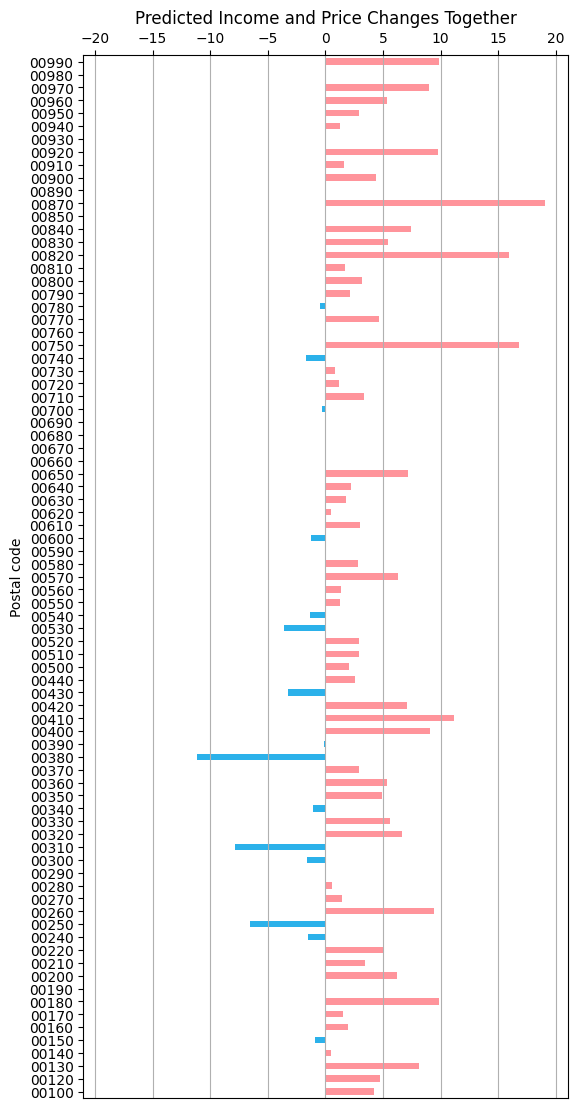

In [17]:
# Plot the percent changes.
limit = results['Percent Change'].map(lambda _: abs(_)).max()
_ = results['Percent Change'].plot(color = np.where(results['Percent Change'] < 0, '#2BB1EA', '#FF949B'),
                                   figsize = (600/96, 1300/96), kind = 'barh')
_.set_title('Predicted Income and Price Changes Together')
_.set_xlim(-limit - 2, limit + 2)
_.xaxis.grid(True)
_.xaxis.tick_top()

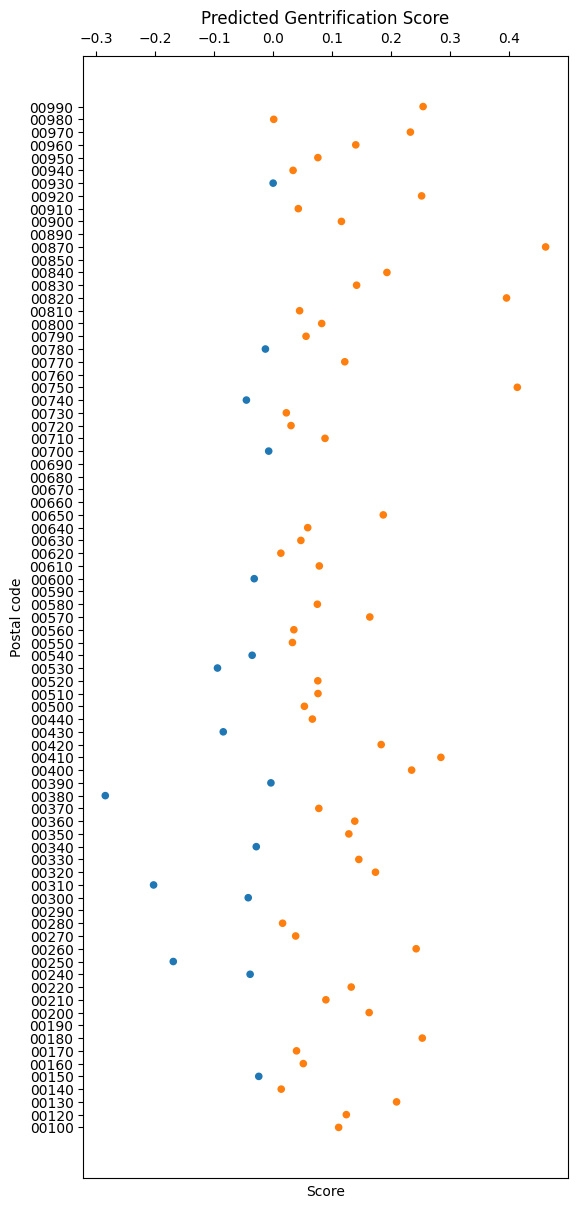

In [18]:
# Plot the "gentrification scores".
# As a side note, way too many positives: almost all areas are gentrifying according to our "analysis".
# One reason for this is that we do not take into account in any way the general increase in income
# and prices (due to, for instance, inflation, which is never 0%).
_ = results.plot.scatter(c = np.where(results['Score'] < 0, 'C0', 'C1'),
                         x = 'Score',
                         y = 'Postal code',
                         figsize = (600/96, 1400/96))
_.set_title('Predicted Gentrification Score')
_.xaxis.tick_top()

In [19]:
from os import path
from tempfile import gettempdir

json_file = path.join(gettempdir(), 'gentrification.json')
results[['Percent Change', 'Score']].to_json(json_file, indent = 2, orient = 'index')
print(f'Results written into "{json_file}".')

Results written into "/var/folders/tp/ycp57sm12qq_g7_xmm5n8s300000gn/T/gentrification.json".
